# Extract participants at COP25

This notebook parses an HTML file generated from the [provisional list of participants](https://unfccc.int/sites/default/files/resource/COP%2025_Provisional%20List%20of%20Participants.pdf) published by the UNFCCC Secretariat for COP25.

Some statistics and plots are displayed at the end of the notebook.

In [1]:
from lxml import html
import matplotlib.pyplot as plt

%matplotlib inline

## Load and parse HTML

In [2]:
with open('participants.html') as f:
    text = ' '.join(f.readlines()).replace('\n', '')

tree = html.fromstring(text)

## Define identifiers for elements

In [3]:
elem2style = {
    'section': "font-family: BCDEEE+Cambria-Bold; font-size:12px",
    'party': "font-family: BCDFEE+Cambria-BoldItalic; font-size:9px",
    'participant1': "font-family: BCDFEE+Cambria; font-size:9px",
    'participant2': "font-family: BCDGEE+Cambria; font-size:9px",
    'participant3': "font-family: BCDHEE+Cambria; font-size:9px",
    'header': "font-family: TimesNewRomanPS-BoldMT; font-size:8px",
    'line': "position:absolute; border: black 1px solid; left:55px; top:986px; width:484px; height:0px;"
}

style2elem = {v: k for k, v in elem2style.items()}

def get_elem(span):
    return style2elem.get(span.attrib['style'])

## Assign level to each element

I use the following hierarchy:

- **Level 0:** Sections (Parties, NGOs, ...)
- **Level 1:** Parties (Switzerland, WWF, ...)
- **Level 2:** Participants (name and affiliation, when available)

In [4]:
spans = tree.xpath('''/html/body/div/span''')

tuples = list()
for span in spans:
    elem = get_elem(span)
    text = span.text_content()
    if elem == 'section':
        tuples.append((text, 0))
    elif elem == 'party':
        tuples.append((text, 1))
    elif elem == 'participant1':
        tuples.append((text, 2))
    elif elem == 'participant2':
        tuples.append((text, 2))
    elif elem == 'participant3':
        tuples.append((text, 2))

## Generate data

Construct a dictionary from the levels defined above.

In [5]:
data = dict()

for entity, level in tuples:
    entity = entity.strip()
    entity = entity.replace('   ', '\n')
    if entity == '':
        continue
    if level == 0:
        data[entity] = dict()
        section = entity
    elif level == 1:
        data[section][entity] = list()
        party = entity
    else:
        data[section][party].append(entity)

## Statistics


### Participation

From the original PDF:

```
13635: Parties
 8499: Non-governmental organizations
  790: Intergovernmental organizations
  381: Specialized agencies and related organizations
  317: United Nations Secretariat units and bodies
    8: Observer States
```

Not explicit in the official document, but mentioned in their summary:
```
3076: Media
```

**Note:** There is a discrepancy of about 4000 participants between my script and the official document, but I cannot find where it comes from... Especially since I'm overcounting some participants due to noise in raw data. 


In [6]:
stats = dict()
for section, parties in data.items():
    c = 0
    for party, participants in parties.items():
        c += len(participants)
    stats[section] = c
for section, c in sorted(stats.items(), key=lambda k: k[1], reverse=True):
    print('{:>4}: {}'.format(c, section))

9278: Parties
8401: Non-governmental organizations
 856: Intergovernmental organizations
 416: Specialized agencies and related organizations
 345: United Nations Secretariat units and bodies
   7: Observer States


### Number of participants per party

385: Côte d'Ivoire
321: Democratic Republic of the Congo
206: Benin
201: Canada
187: Spain
186: Brazil
186: Indonesia
182: Guinea
176: Congo
173: Morocco
171: Bangladesh
165: Japan
140: European Union
137: Burkina Faso
137: Chile
131: France
131: Sudan
126: Uganda
124: Senegal
115: Germany


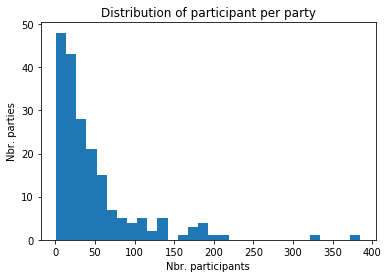

In [7]:
parties_count = {party: len(participants) for party, participants in data['Parties'].items()}
for party, count in sorted(parties_count.items(), key=lambda k: k[1], reverse=True)[:20]:
    print('{:>3}: {}'.format(count, party))
    
plt.hist(parties_count.values(), bins=30)
plt.title('Distribution of participant per party')
plt.xlabel('Nbr. participants')
plt.ylabel('Nbr. parties')
plt.show()

### Number of participants per NGO

194: International Chamber of Commerce
166: Climate Action Network International
158: International Trade Union Confederation
148: International Emissions Trading Association
 95: Greenpeace International
 95: ICLEI-Local Governments for Sustainability
 88: WWF
 79: World Farmers' Organisation
 73: Climate Action Network - Latin America
 72: Climate Action Network - Europe
 56: Friends of the Earth International
 56: Women's Environment and Development Organization
 51: Association Actions Vitales Pour Le Développement Durable
 50: World Business Council for Sustainable Development
 45: University of California
 44: GenderCC - Women for Climate Justice e.V.
 44: Sustainable Markets Foundation - 350.org
 40: Réseau Action Climat - France
 38: Deutsche Gesellschaft für Internationale Zusammenarbeit
 35: China New Energy Chamber of Commerce


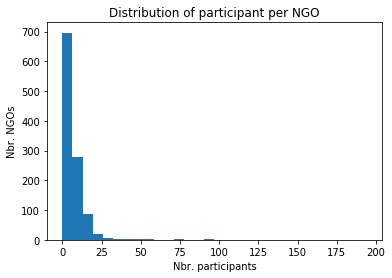

In [8]:
ngos_count = {ngo: len(participants) for ngo, participants in data['Non-governmental organizations'].items()}
for ngo, count in sorted(ngos_count.items(), key=lambda k: k[1], reverse=True)[:20]:
    print('{:>3}: {}'.format(count, ngo))
    
plt.hist(ngos_count.values(), bins=30)
plt.title('Distribution of participant per NGO')
plt.xlabel('Nbr. participants')
plt.ylabel('Nbr. NGOs')
plt.show()

### Partipants linked to the fossil-fuel industry

In [9]:
keywords = [
    'petroleum',
    'oil',
    'gas',
    'shell',
    'coal',
    'bp',
    'gazprom',
    'total',
    'aramco',
    'petrochemical',
    'ipieca',
    'eni',
    'lafargeholcim',
    'suncor'
]

ngos = [
    'european union of the natural gas industry',
    'international association of oil and gas producers*',
    'chamber of commerce of the united states of america',
    'competitive enterprise institute',
    'committee for a constructive tomorrow',
    'international council of chemical associations',
    
]

def compare_keywords(name):
    name = name.replace('\n',' ').lower()
    for ngo in ngos:
        if name == ngo:
            return True
    name = name.lower().split()
    for kw in keywords:
        if kw in name:
            return True
    return False

In [10]:
badguys = set()

for section, parties in data.items():
    for party, participants in parties.items():
        if compare_keywords(party):
            badguys.update(participants)
        for participant in participants:
            if compare_keywords(participant):
                badguys.add(participant)

print('Identified {} participants linked to the fossil-fuel industry.'.format(len(badguys)))

Identified 186 participants linked to the fossil-fuel industry.
